In [1]:
#Load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from random import randrange, uniform

In [3]:
# Load Data - Train Data
Train_Data=(pd.read_csv('cab.csv', header = 0 )).drop(columns="pickup_datetime")

In [4]:
#Eliminate rows where the pickup and drop location points are same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]
#replace 0 with NA in the variables and convert the data wherever required for further operations

Train_Data['fare_amount']= Train_Data['fare_amount'].apply(pd.to_numeric, errors='coerce')
Train_Data['fare_amount']= Train_Data['fare_amount'].replace({0:np.nan})
Train_Data['passenger_count']=Train_Data['passenger_count'].fillna(0)
Train_Data['passenger_count']= Train_Data['passenger_count'].astype(int)
Train_Data['passenger_count']=Train_Data['passenger_count'].replace({0: np.nan})
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].replace({0:np.nan})
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].replace({0:np.nan})
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].replace({0:np.nan})
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].replace({0:np.nan})

In [5]:
Train_Data.shape

(15603, 6)

In [29]:
Train_Data.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist
0,4.50000,-73.981697,40.721319,-73.980230,40.712278,1,1.012886
1,16.90000,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,5.70000,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,7.70000,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,5.30000,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
5,12.10000,-74.000964,40.731630,-73.972892,40.758233,1,3.787239
6,7.50000,-73.980002,40.751662,-73.973802,40.764842,1,1.555807
7,16.50000,-73.951300,40.774138,-73.990095,40.751048,1,4.155444
8,15.12833,-74.006462,40.726713,-73.993078,40.731628,1,1.253232
9,8.90000,-73.980658,40.733873,-73.991540,40.758138,2,2.849627


In [6]:
#calculate missing values

missing_val = pd.DataFrame(Train_Data.isnull().sum())
#print(missing_val)

#Reset index
missing_val = missing_val.reset_index()
#print(missing_val)

#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'count'})
#print(missing_val)

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['count']/len(Train_Data)*100)
#print(missing_val)

#sort in descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
print(missing_val)

           Variables  count  Missing_percentage
0    passenger_count    112            0.717811
1        fare_amount     24            0.153817
2   pickup_longitude     12            0.076908
3    pickup_latitude     12            0.076908
4  dropoff_longitude     10            0.064090
5   dropoff_latitude      9            0.057681


In [7]:
#imputation method 
#Actual value = -73.99578100000001
#Mean = -73.91159336554888
#Median = -73.9820605
#KNN = -73.890529
#Create missing value, a small test to identify which method is good for imputation

Train_Data["pickup_longitude"].loc[70]

-73.995781

In [8]:
Train_Data["pickup_longitude"].loc[70] = np.nan
Train_Data["pickup_longitude"].loc[70]

nan

In [9]:
#Mean Imputation
#Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())

#Train_Data["pickup_longitude"].loc[70]
#Median Imputation
#Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].median())

#Train_Data["pickup_longitude"].loc[70]
#KNN imputation
#Train_Data = pd.DataFrame(KNN(k = 1).fit_transform(Train_Data), columns = Train_Data.columns)

#Train_Data["pickup_longitude"].loc[70]

In [10]:
#As it is found Mean is very close to original method we will proceed with imputation via mean
Train_Data['fare_amount'] = Train_Data['fare_amount'].fillna(Train_Data['fare_amount'].mean())
Train_Data['pickup_longitude']= Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude']= Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude']= Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude']= Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())


#And for category variables imputation is done with mode
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))
#Imputing the NAs in target variables may hamper the model, so it is preferred to remove NA rows of the data
Train_Data=Train_Data.dropna()
#conert into proper data type
convert_dic={'fare_amount' : 'float','passenger_count': 'int'}
Train_Data=Train_Data.astype(convert_dic)
Train_Data.shape

(15603, 6)

In [11]:
#save the data with in another place with different name

df = Train_Data.copy()
Train_Data = Train_Data.copy()
# irregular fare_amount are converted to NA 

Train_Data.loc[Train_Data['fare_amount']<0 , 'fare_amount']=np.nan
Train_Data.loc[Train_Data['fare_amount'] > 30, 'fare_amount']=np.nan
Train_Data=Train_Data.dropna()
#irregular passenger counts or those wgich are greater then 8 convertet to NaN
Train_Data.loc[Train_Data['passenger_count'] > 8,'passenger_count'] = np.nan

In [12]:
#save numeric data names
coutliers = [ 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for list in coutliers:
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(Train_Data[list], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
   
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)

    # #Replace with NA
    Train_Data.loc[Train_Data[list] < minimum,list] = np.nan
    Train_Data.loc[Train_Data[list] > maximum,list] = np.nan

    # #Calculate missing value
    missing_val = pd.DataFrame(Train_Data.isnull().sum())

In [13]:
#As Mean is the best method, we impute missing values/ in this case outlier values with mean

Train_Data['pickup_longitude'] = Train_Data['pickup_longitude'].fillna(Train_Data['pickup_longitude'].mean())
Train_Data['pickup_latitude'] = Train_Data['pickup_latitude'].fillna(Train_Data['pickup_latitude'].mean())
Train_Data['dropoff_longitude'] = Train_Data['dropoff_longitude'].fillna(Train_Data['dropoff_longitude'].mean())
Train_Data['dropoff_latitude'] = Train_Data['dropoff_latitude'].fillna(Train_Data['dropoff_latitude'].mean())

#imputed with mode for categorical variables
Train_Data['passenger_count'] = Train_Data['passenger_count'].fillna(int(Train_Data['passenger_count'].mode()))
#convert the data type of categorical variable passenger count
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('int')
Train_Data['passenger_count']=Train_Data['passenger_count'].astype('category')

In [15]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))
Train_Data['dist'] = \
    haversine( Train_Data['pickup_latitude'], Train_Data['pickup_longitude'],
                Train_Data['dropoff_latitude'], Train_Data['dropoff_longitude'])
##Correlation analysis
#Correlation plot
numeric=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', 'dist']
Train_Data_corr = Train_Data.loc[:,numeric]

                   fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000         -0.048822        -0.057861   
pickup_longitude     -0.048822          1.000000         0.667819   
pickup_latitude      -0.057861          0.667819         1.000000   
dropoff_longitude     0.047996          0.364438         0.293342   
dropoff_latitude     -0.077377          0.318268         0.442597   
dist                  0.670136         -0.045966        -0.081138   

                   dropoff_longitude  dropoff_latitude      dist  
fare_amount                 0.047996         -0.077377  0.670136  
pickup_longitude            0.364438          0.318268 -0.045966  
pickup_latitude             0.293342          0.442597 -0.081138  
dropoff_longitude           1.000000          0.595164  0.063158  
dropoff_latitude            0.595164          1.000000 -0.061745  
dist                        0.063158         -0.061745  1.000000  


C:\Users\DHARMI~1\AppData\Local\Temp/ipykernel_12908/2440352122.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

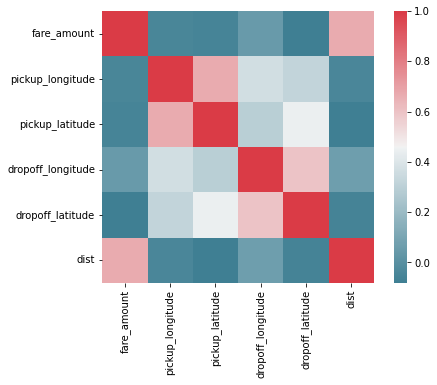

In [16]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = Train_Data_corr.corr()
print(corr)

#Plotted using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

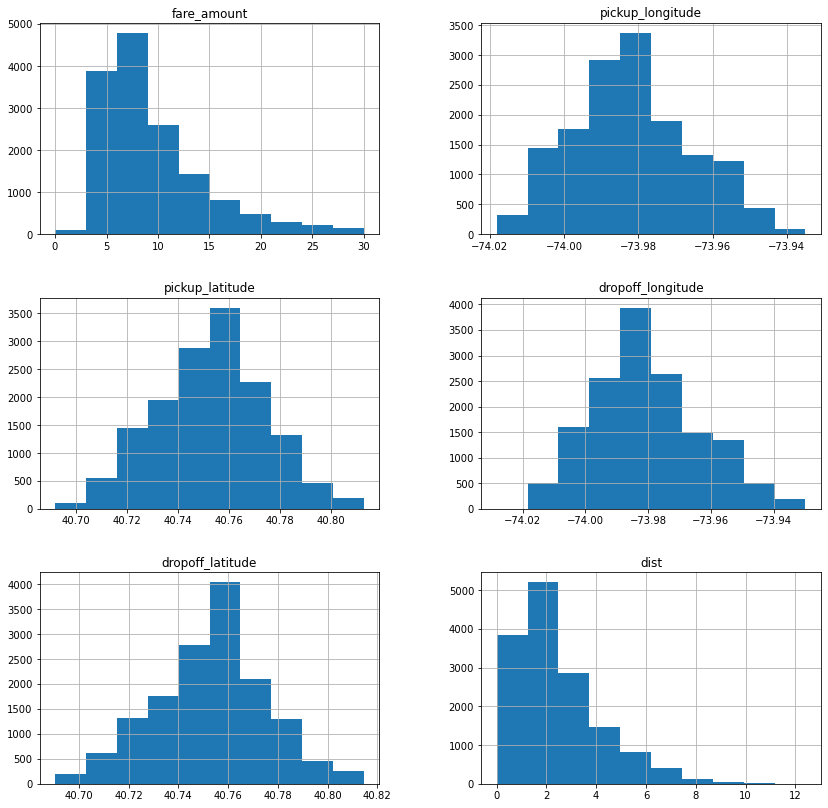

In [17]:
#eliminate all data with the pickup and drop location points as same

Train_Data=Train_Data[np.logical_and(Train_Data['pickup_longitude'] != Train_Data['dropoff_longitude'],
                                     Train_Data['pickup_latitude'] != Train_Data['dropoff_latitude'])]
Train_Data.hist(figsize=(14,14))
plt.show()

<Figure size 1440x1440 with 0 Axes>

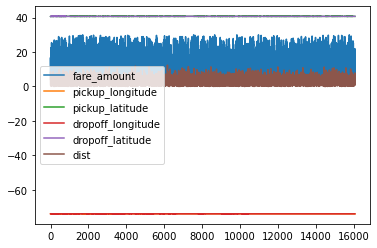

In [18]:
plt.figure(figsize=(20,20))
Train_Data.plot()
plt.show()

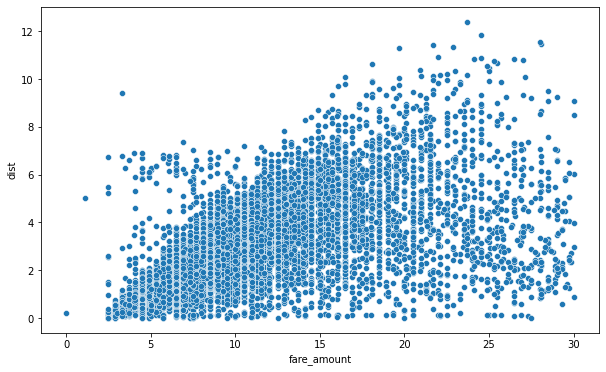

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'fare_amount', y='dist', data = Train_Data)
plt.show()

<Figure size 720x576 with 0 Axes>

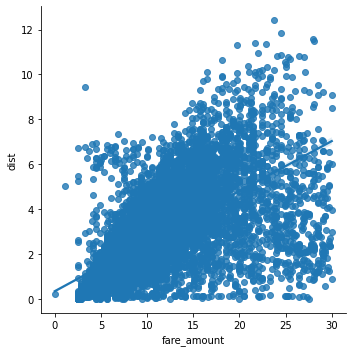

In [20]:
plt.figure(figsize=(10,8))
sns.lmplot(x = 'fare_amount', y='dist', data = Train_Data)
plt.show()

In [21]:
#Load libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
# Divide the data into train and test
train1, test1 = train_test_split(Train_Data, test_size=0.2)
# Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train1.iloc[:, 1:7], train1.iloc[:,0])
fit_DT

DecisionTreeRegressor(max_depth=2)

In [22]:
#Apply model on test data
predictions_DT = fit_DT.predict(test1.iloc[:,1:7])
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape
MAPE(test1.iloc[:,0], predictions_DT)

50.439190314944994

In [23]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators = 10).fit(train1.iloc[:, 1:7], train1.iloc[:,0])
RF_model
RandomForestRegressor(n_estimators=10)
RF_Predictions = RF_model.predict(test1.iloc[:, 1:7])
MAPE(test1.iloc[:,0], RF_Predictions)

41.36521547118936

In [24]:
#Combine all the values in one array
values=['fare_amount', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'dist']
linear_Data = Train_Data[values]
#This function is developed to get columns for specific passenger count. The idea is developed from R linear regression fit, 
#which explains all the passenger count individualy contributes in the model 

cat_names = ['passenger_count'] 
for i in cat_names:
    temp = pd.get_dummies(Train_Data[i], prefix= i)
    linear_Data = linear_Data.join(temp)
linear_Data.shape

(14795, 12)

In [25]:
linear_Data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
0,4.5,-73.981697,40.721319,-73.980230,40.712278,1.012886,1,0,0,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,8.450134,1,0,0,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,1.389525,0,1,0,0,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2.799270,1,0,0,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.999157,1,0,0,0,0,0


In [26]:
#Spliting the newly created data set with passenger count dummies
train1, test1 = train_test_split(linear_Data, test_size=0.2)
#Import libraries for LR
import statsmodels.api as sm
# Train the model using the training sets
model = sm.OLS(train1.iloc[:, 0].astype(float), train1.iloc[:, 1:12].astype(float)).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     992.5
Date:                Thu, 05 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:07:37   Log-Likelihood:                -32668.
No. Observations:               11836   AIC:                         6.536e+04
Df Residuals:                   11825   BIC:                         6.544e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
pickup_longitude    -14.6164      3.039     -4.809      0.000     -20.574      -8.659
pickup_latitude       9.1394      2.348      3.892      0.000       4.536      13.742
dropoff_longitude    13.4959      2.697      5.005      0.000       8.210      18.782
dropoff_latitude    -14.9695      2.121     -7.057      0.000     -19.128     -10.811
dist                  1.9991      0.021     97.174      0.000       1.959       2.039
passenger_count_1   159.2639    338.594      0.470      0.638    -504.436     822.964
passenger_count_2   159.3277    338.596      0.471      0.638    -504.377     823.032
passenger_count_3   159.5104    338.597      0.471      0.638    -504.196     823.217
passenger_count_4   159.4376    338.599      0.471      0.638    -504.273     823.148
passenger_count_5   159.1378    338.595      0.470      0.638    -504.564     822.839
passenger_count_6   160.2276    338.595      0.473      0.636    -503.474     823.929
==============================================================================
Omnibus:                     5953.407   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44594.388
Skew:                           2.313   Prob(JB):                         0.00
Kurtosis:                      11.308   Cond. No.                     2.82e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# make the predictions by the model
predictions_LR = model.predict(test1.iloc[:,1:12])
#Calculate MAPE
MAPE(test1.iloc[:,0], predictions_LR)

26.742368832409785

In [28]:
#KNN implementation
from sklearn.neighbors import KNeighborsRegressor

KNN_model = KNeighborsRegressor(n_neighbors = 1).fit(train1.iloc[: , 1:7], train1.iloc[:, 0])
#predict test cases
KNN_Predictions = KNN_model.predict(test1.iloc[: , 1:7])
MAPE(test1.iloc[:,0], KNN_Predictions)

35.07284799397776